In [1]:
import numpy as np
import tensorflow as tf
from collections import OrderedDict

In [2]:
#fn0 = '/home/ron/Downloads/lil_s2.tif'
fn1 = '/run/media/ron/silver_small/s2/S2_10.tif'
fn2 = '/run/media/ron/silver_small/s2/S2_20.tif'

fn3 = '/run/media/ron/silver_small/s2/S2L2A_10.tif'

attempt=58

num_channels = 4
len_edge = 32 # of higher resolution image
bs = 16

#h_dim = 1000
latent_dim = 30 * 30

latvisdim = int(np.sqrt(latent_dim))
tb_imgs_to_display = 4

train_size = 1600
valid_size = 64

recording_interval = 500
epochs = 1000000

testlogpath = './vae_logs/test/' + str(attempt)
trainlogpath = './vae_logs/train/' + str(attempt)
genlogpath = './vae_logs/gen/' + str(attempt)

In [3]:
def normalization_parameters(fn):
    from osgeo import gdal
    S = gdal.Open(fn)
    mns = []
    sds = []
    maxs = []
    
    for b in range(S.RasterCount):
        B = S.GetRasterBand(b+1)
        mn, sd = B.ComputeStatistics(1)[2:4]
        mns.append(mn)
        sds.append(sd)
        maxs.append(B.GetMaximum())
        
    return([mns, sds, maxs])

def sample_1s2(filebase, batchsize, tilesize=128, normalize=False, flattened=False):
    import numpy as np
    from osgeo import gdal   
    
    if type(filebase) == str:
        multires = False
        S2_10 = gdal.Open(filebase)
        if normalize:
            maxima_10 = np.array(normalization_parameters(filebase)[2])
        
    elif type(filebase) == list:#interpreted as multiple resolutions
        tilesize = tilesize/2
        multires = True
        S2_10 = gdal.Open(filebase[0])
        S2_20 = gdal.Open(filebase[1])
        if normalize:
            maxima_10 = np.array(normalization_parameters(filebase[0])[2])
            maxima_20 = np.array(normalization_parameters(filebase[1])[2])
    
    samples_10 = []
    
    if multires:        
        samples_20 = []
        
        while len(samples_10) < batchsize:
            RX = np.random.randint(S2_20.RasterXSize-tilesize,size=1)
            RY = np.random.randint(S2_20.RasterYSize-tilesize,size=1)
            
            A_10 = np.transpose(S2_10.ReadAsArray(RX[0] * 2, RY[0] * 2, tilesize * 2, tilesize * 2)).astype(np.float32)
            A_20 = np.transpose(S2_20.ReadAsArray(RX[0], RY[0], tilesize, tilesize)).astype(np.float32)
            
            if (np.min(A_10) > 0) & (np.min(A_20) > 0):
                if normalize:
                    A_10 = A_10 / maxima_10
                    A_20 = A_20 / maxima_20
                if flattened:
                    A_10 = A_10.flatten()
                    A_20 = A_20.flatten()
                    
                samples_10.append(A_10)
                samples_20.append(A_20)
                
        return([np.array(samples_10), np.array(samples_20)])
                
    else:
        while len(samples_10) < batchsize:
            RX = np.random.randint(S2_10.RasterXSize-tilesize,size=1)
            RY = np.random.randint(S2_10.RasterYSize-tilesize,size=1)
            
            A_10 = np.transpose(S2_10.ReadAsArray(RX[0], RY[0], tilesize, tilesize).astype(np.float32))
            
            if np.min(A_10) > 0:            
                if normalize:
                    A_10 = A_10 / maxima_10
                if flattened:
                    A_10 = A_10.flatten()
                    
                samples_10.append(A_10)
                
        return(np.array(samples_10))

In [4]:
layer_name_dict = {}
def layer_name(base_name):
    if base_name not in layer_name_dict:
        layer_name_dict[base_name] = 0
    layer_name_dict[base_name] += 1
    name = base_name + str(layer_name_dict[base_name])
    return name

In [5]:
def convolute(inp, name, kernel_size = 3, out_chans = 64, sz = 1):
    inp_chans = inp.get_shape().as_list()[-1]
    with tf.variable_scope(name) as scope:
        W = tf.get_variable('weights', [kernel_size, kernel_size, inp_chans, out_chans], initializer=tf.contrib.layers.xavier_initializer_conv2d(), regularizer=tf.contrib.layers.l2_regularizer(0.0005))#, name='weights')
        b = tf.get_variable('biases', [out_chans], initializer=tf.constant_initializer(0.0), regularizer=None, dtype=tf.float32)
        conv = tf.nn.conv2d(inp, W, strides=[1, sz, sz, 1], padding='SAME')
        conv = tf.contrib.layers.batch_norm(conv, scope=scope) # train?
        conv = tf.nn.relu(conv+b)
#        conv = tf.nn.dropout(conv, 0.8)
    return conv

def pooling(inp, name, factor=2):
    pool = tf.nn.max_pool(inp, ksize=[1, factor, factor, 1], strides=[1, factor, factor, 1], padding='SAME', name=name)
    return pool

In [6]:
innest = 256
inner = 128
middle = 128
outer = 64
#outest = 16

with tf.name_scope('Input'):
    X = tf.placeholder(tf.float32, shape=([None, len_edge, len_edge, num_channels]))#bs
    if num_channels == 2:
        X_show = tf.concat([X, tf.expand_dims(X[:, :, :, 1], 3)], axis=3)
        tf.summary.image('input_images', X_show, max_outputs=tb_imgs_to_display)
    elif num_channels > 3:
        tf.summary.image('input_images', X[:, :, :, 0:3], max_outputs=tb_imgs_to_display)
    else:
        tf.summary.image('input_images', X, max_outputs=tb_imgs_to_display)

dw_h_convs = OrderedDict()
up_h_convs = OrderedDict()

#Build the network
X_go = X

X_go = convolute(X, layer_name('conv'), 3, outer, sz = 1)
dw_h_convs[0] = convolute(X_go,layer_name('conv'),3,outer,sz = 1)
X_go = pooling(dw_h_convs[0], 'pool1')

dw_h_convs[1] = convolute(X_go,layer_name('conv'),3,middle)
dw_h_convs[1] = convolute(dw_h_convs[1],layer_name('conv'),3,middle)
dw_h_convs[2] = pooling(dw_h_convs[1], 'pool2')

dw_h_convs[2] = convolute(dw_h_convs[2],layer_name('conv'),3,inner)
dw_h_convs[2] = convolute(dw_h_convs[2],layer_name('conv'),3,inner)
dw_h_convs[3] = pooling(dw_h_convs[2], 'pool3')

dw_h_convs[3] = convolute(dw_h_convs[3],layer_name('conv'),3,innest)
dw_h_convs[3] = convolute(dw_h_convs[3],layer_name('conv'),3,innest)
dw_h_convs[4] = pooling(dw_h_convs[3], 'pool4')


In [7]:
flattened = tf.reshape(dw_h_convs[4], [-1, 2 * 2 * innest])

#W_enc = tf.get_variable('W_enc', [4 * 4 * 512, h_dim], initializer=tf.contrib.layers.xavier_initializer())
#b_enc = tf.get_variable('b_enc', [h_dim], initializer=tf.constant_initializer(0.0), regularizer=None, dtype=tf.float32)
#full1 = tf.nn.dropout(tf.nn.relu(tf.contrib.layers.batch_norm(tf.matmul(flattened, W_enc) + b_enc)), 0.5)

#W_mu = tf.get_variable('W_mu', [h_dim, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
W_mu = tf.get_variable('W_mu', [2 * 2 * innest, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
b_mu = tf.get_variable('b_mu', [latent_dim], initializer=tf.constant_initializer(0.0), regularizer=None, dtype=tf.float32)
#mu = tf.matmul(full1, W_mu) + b_mu
mu = tf.matmul(flattened, W_mu) + b_mu


W_logstd = tf.get_variable('W_logstd', [2 * 2 * innest, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
#W_logstd = tf.get_variable('W_logstd', [h_dim, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
b_logstd = tf.get_variable('b_logstd', [latent_dim], initializer=tf.constant_initializer(0.0), regularizer=None, dtype=tf.float32)
logstd = tf.matmul(flattened, W_logstd) + b_logstd
#logstd = tf.matmul(full1, W_logstd) + b_logstd

noise = tf.random_normal([1, latent_dim])
z = mu + tf.multiply(noise, tf.exp(.5*logstd))

In [8]:
z_visual = tf.reshape(z, [-1, latvisdim, latvisdim, 1])
tf.summary.image('latents', z_visual, max_outputs=tb_imgs_to_display)

#W_dec = tf.get_variable('W_dec', [latent_dim, h_dim], initializer=tf.contrib.layers.xavier_initializer())
#b_dec = tf.get_variable('b_dec', [h_dim], initializer=tf.constant_initializer(0.0), regularizer=None, dtype=tf.float32)
#full2 = tf.nn.dropout(tf.nn.relu(tf.contrib.layers.batch_norm(tf.matmul(z, W_dec) + b_dec)), 0.5)

W_dec2 = tf.get_variable('W_dec2', [latent_dim, 2 * 2 * innest], initializer=tf.contrib.layers.xavier_initializer())
#W_dec2 = tf.get_variable('W_dec2', [h_dim, 4 * 4 * inner], initializer=tf.contrib.layers.xavier_initializer())
b_dec2 = tf.get_variable('b_dec2', [2 * 2 * innest], initializer=tf.constant_initializer(0.0), regularizer=None, dtype=tf.float32)

#full3 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.matmul(full2, W_dec2) + b_dec2))
full3 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.matmul(z, W_dec2) + b_dec2))

reshaped = tf.reshape(full3, [-1, 2, 2, innest])

up_h_convs[0] = tf.image.resize_images(reshaped, [ reshaped.get_shape().as_list()[1]*2, 
                                                            reshaped.get_shape().as_list()[2]*2] )

#up_h_convs[0] = tf.concat([up_h_convs[0], dw_h_convs[3] ],3 ) 

up_h_convs[0] = convolute(up_h_convs[0], layer_name('conv'), 3, innest)
up_h_convs[0] = convolute(up_h_convs[0], layer_name('conv'), 3, innest)
up_h_convs[1] = tf.image.resize_images(up_h_convs[0], [ up_h_convs[0].get_shape().as_list()[1]*2, 
                                                            up_h_convs[0].get_shape().as_list()[2]*2] ) 

#up_h_convs[1] = tf.concat([up_h_convs[1], dw_h_convs[2] ],3 ) 
up_h_convs[1] = convolute(up_h_convs[1], layer_name('conv'), 3, inner)
up_h_convs[1] = convolute(up_h_convs[1], layer_name('conv'), 3, inner)
up_h_convs[2] = tf.image.resize_images(up_h_convs[1], [ up_h_convs[1].get_shape().as_list()[1]*2, 
                                                            up_h_convs[1].get_shape().as_list()[2]*2] ) 

#up_h_convs[2] = tf.concat([up_h_convs[2], dw_h_convs[1] ],3 ) 
up_h_convs[2] = convolute(up_h_convs[2], layer_name('conv'), 3, middle)
up_h_convs[2] = convolute(up_h_convs[2], layer_name('conv'), 3, middle)
up_h_convs[3] = tf.image.resize_images(up_h_convs[2], [ up_h_convs[2].get_shape().as_list()[2]*2, 
                                                            up_h_convs[2].get_shape().as_list()[2]*2] ) 

#up_h_convs[3] = tf.concat([up_h_convs[3], dw_h_convs[0] ],3 ) 
up_h_convs[3] = convolute(up_h_convs[3], layer_name('conv'), 3, outer)
up_h_convs[3] = convolute(up_h_convs[3], layer_name('conv'), 3, outer)

W_rec = tf.get_variable('weights_rec', [1, 1, outer, 4], initializer=tf.contrib.layers.xavier_initializer_conv2d(), regularizer=False)#, name='weights')
b_rec = tf.get_variable('biases_rec', [4], initializer=tf.constant_initializer(0.0), regularizer=None, dtype=tf.float32)
reconstruction = tf.nn.sigmoid(tf.nn.conv2d(up_h_convs[3], W_rec, strides=[1, 1, 1, 1], padding='SAME') + b_rec)

In [9]:
with tf.name_scope('reconst'):
    if num_channels == 2:
        r_show = tf.concat([reconstruction, tf.expand_dims(reconstruction[:, :, :, 1], 3)], axis=3)
        tf.summary.image('reconstructed_images', r_show, max_outputs=tb_imgs_to_display)
    elif num_channels > 3:
        tf.summary.image('reconstructed_images', reconstruction[:, :, :, 0:3], max_outputs=tb_imgs_to_display)
    else:
        tf.summary.image('reconstructed_images', reconstruction, max_outputs=tb_imgs_to_display)

In [10]:
_z = tf.placeholder(tf.float32, shape=([None, latent_dim]))
_up_h_convs = OrderedDict()

#_full2 = tf.nn.dropout(tf.nn.relu(tf.contrib.layers.batch_norm(tf.matmul(_z, W_dec) + b_dec)), 0.5)
_full3 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.matmul(_z, W_dec2) + b_dec2))
_reshaped = tf.reshape(_full3, [-1, 2, 2, innest])

_up_h_convs[0] = tf.image.resize_images(_reshaped, [ _reshaped.get_shape().as_list()[1]*2, 
                                                            _reshaped.get_shape().as_list()[2]*2] )
_up_h_convs[0] = convolute(_up_h_convs[0], layer_name('conv'), 3, innest)
_up_h_convs[0] = convolute(_up_h_convs[0], layer_name('conv'), 3, innest)

_up_h_convs[1] = tf.image.resize_images(_up_h_convs[0], [ _up_h_convs[0].get_shape().as_list()[1]*2, 
                                                            _up_h_convs[0].get_shape().as_list()[2]*2] ) 

_up_h_convs[1] = convolute(_up_h_convs[1], layer_name('conv'), 3, inner)
_up_h_convs[1] = convolute(_up_h_convs[1], layer_name('conv'), 3, inner)
_up_h_convs[2] = tf.image.resize_images(_up_h_convs[1], [ _up_h_convs[1].get_shape().as_list()[1]*2, 
                                                            _up_h_convs[1].get_shape().as_list()[2]*2] ) 

_up_h_convs[2] = convolute(_up_h_convs[2], layer_name('conv'), 3, middle)
_up_h_convs[2] = convolute(_up_h_convs[2], layer_name('conv'), 3, middle)
_up_h_convs[3] = tf.image.resize_images(_up_h_convs[2], [ _up_h_convs[2].get_shape().as_list()[2]*2, 
                                                            _up_h_convs[2].get_shape().as_list()[2]*2] ) 
_up_h_convs[3] = convolute(_up_h_convs[3], layer_name('conv'), 3, outer)
_up_h_convs[3] = convolute(_up_h_convs[3], layer_name('conv'), 3, outer)

_reconstruction = tf.nn.sigmoid(tf.nn.conv2d(_up_h_convs[3], W_rec, strides=[1, 1, 1, 1], padding='SAME') + b_rec)

In [11]:
X_flat = tf.contrib.layers.flatten(X)
R_flat = tf.contrib.layers.flatten(reconstruction)
log_likelihood = tf.reduce_sum(X_flat*tf.log(R_flat + 1e-9)+(1 - X_flat)*tf.log(1 - R_flat + 1e-9), reduction_indices=1)


#if multires_filters > 0:
#    X2_flat = tf.contrib.layers.flatten(X2)
#    R2_flat = tf.contrib.layers.flatten(reconstruction_low)
#    
#    log_likelihood2 = tf.reduce_sum(X2_flat*tf.log(R2_flat + 1e-9)+(1 - X2_flat)*tf.log(1 - R2_flat + 1e-9), reduction_indices=1)
#    log_likelihood = log_likelihood + log_likelihood2

#log_likelihood = tf.reduce_sum(X_flat*tf.log(R_flat + 1e-9)+(1 - X_flat)*tf.log(1 - R_flat + 1e-9), reduction_indices=1)
tf.summary.scalar('LogLike', tf.reduce_mean(log_likelihood))

KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)
tf.summary.scalar('KL', tf.reduce_mean(KL_term))

variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
tf.summary.scalar('cost', variational_lower_bound)

validator = tf.cast(variational_lower_bound, tf.int32) # alibi
optimizer = tf.train.AdamOptimizer(1e-4).minimize(-variational_lower_bound)
optimizer_likeli = tf.train.AdamOptimizer(1e-4).minimize(-log_likelihood)

In [12]:
merged_summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
saver = tf.train.Saver()
train_writer = tf.summary.FileWriter(trainlogpath)
valid_writer = tf.summary.FileWriter(testlogpath)
#gen_writer = tf.summary.FileWriter(genlogpath)
train_writer.add_graph(sess.graph)

In [13]:
X_all = sample_1s2(fn3, train_size, tilesize=len_edge, normalize=True, flattened=False)
x_valid = sample_1s2(fn3, valid_size, tilesize=len_edge, normalize=True, flattened=False)

In [59]:
X_all = sample_1s2(fn3, train_size*30, tilesize=len_edge, normalize=True, flattened=False)

In [75]:
step = bs
ep = 0
for ep in range(epochs):
#    print ep
    x_batch = X_all[step-bs:step]
#    x1_batch = X1_all[step-bs:step]
#    x2_batch = X2_all[step-bs:step]
    
    if (ep%recording_interval == 0):
        vvv, s = sess.run([validator, merged_summary], feed_dict={X: x_valid})
#        vvv, s = sess.run([validator, merged_summary], feed_dict={X: X1_valid, X2: X2_valid})
        valid_writer.add_summary(s, ep)
        
    _, s = sess.run([optimizer, merged_summary], feed_dict={X: x_batch})
#    _, s = sess.run([optimizer, merged_summary], feed_dict={X: x1_batch, X2: x2_batch})
    
    if (ep%recording_interval == 0):
        train_writer.add_summary(s, ep)
        
    step += bs
    
    if step == train_size:
        step = bs

KeyboardInterrupt: 

In [ ]:
z_mu.shape

In [76]:
z_mu = np.random.normal(size=[bs, latent_dim])
hi = sess.run([_reconstruction], feed_dict={_z: z_mu})
#train_writer.add_summary(s, 1)

In [40]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

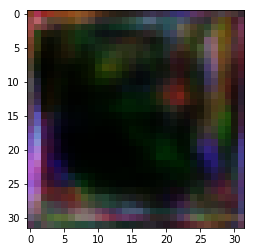

In [85]:
plt.imshow(hi[0][10, :, :, ::-1][:, :, 1:4])